In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/data')

In [ ]:
import tensorflow
import drowsiness_standardisation
import drowsiness_functions
import os
from mlxtend.image import extract_face_landmarks
import cv2
import numpy as np
import pandas as pd
from drowsiness_standardisation import Standardization
import matplotlib.pyplot as plt
import torch
import glob
from IPython.display import clear_output
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,
    MaxPooling2D)
from collections import deque

In [ ]:
!cat '/content/gdrive/MyDrive/data/drowsiness_functions.py'

from scipy.spatial import distance
def eye_aspect_ratio(eye):
    #calculating eye aspect ratio
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def mouth_aspect_ratio(mouth):
    # calculating mouth aspect ratio
    A = distance.euclidean(mouth[14], mouth[18])
    C = distance.euclidean(mouth[12], mouth[16])
    mar = (A ) / (C)
    return mar

def circularity(eye):
    # calculating pupil cicularity
    A = distance.euclidean(eye[1], eye[4])
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance.euclidean(eye[0], eye[1])
    p += distance.euclidean(eye[1], eye[2])
    p += distance.euclidean(eye[2], eye[3])
    p += distance.euclidean(eye[3], eye[4])
    p += distance.euclidean(eye[4], eye[5])
    p += distance.euclidean(eye[5], eye[0])
    return 4 * math.pi * Area / (p**2)

def mouth_over_eye(eye):
    # calculating mouth over eye

In [ ]:
# Extracting 1 FPS in each video starting at 3 minute mark (skip beginning)
def frame_extraction(folder , participants, MAX_FRAMES=240):
    def getFrame(sec):
        #Read the frame from the video and return the frame
        start = 180000      
        vidcap.set(cv2.CAP_PROP_POS_MSEC, start + sec*1000)
        hasFrames, image = vidcap.read()
        return hasFrames, image
    participant, state = 0, 0
    # Loop through all videos in the specific folder
    for j in participants:
        for i in np.arange(0, 11, 5):
            clear_output(wait=True) 
            data = []
            labels = []
            # drive where the UTA videos are located
            vidcap = cv2.VideoCapture(r'/content/gdrive/MyDrive/data/videos/' + str(folder) + '/' + str(j) +'/' + str(i) + '.mov')

            count=0
            sec = 0
            frameRate = 1
            success, image  = getFrame(sec)
            participant = j
            state = i
            # Extract frames (per video), the more frames the longer the extraction takes
            while success and count < MAX_FRAMES: 
                landmarks = extract_face_landmarks(image)
                if landmarks is not None and sum(sum(landmarks)) != 0:
                    data.append(landmarks)
                    labels.append([i])
                    sec = sec + frameRate
                    sec = round(sec, 2)
                    success, image = getFrame(sec)
                    count=count+1
                else:  
                    sec = sec + frameRate
                    sec = round(sec, 2)
                    success, image = getFrame(sec)
                    print("not detected")
            if success:
                data = np.array(data)
                labels = np.array(labels)
                features = []
                for d in data:
                    # extract relevant facial landmarks from dlib shape predictor
                    landmarks = d[36:68]
                    # here we create our features for our classifier
                    ear = eye_aspect_ratio(landmarks)
                    mar = mouth_aspect_ratio(landmarks)
                    cir = circularity(landmarks)
                    mouth_eye = mouth_over_eye(landmarks)
                    features.append([int(participant), ear, mar, cir, mouth_eye])
                features = np.array(features)
              
                # save captured data as csv files
                np.savetxt('/content/gdrive/MyDrive/data/drowsiness_formula_files/' + str(folder) +'_features_'+str(participant)+'_'+str(state)+'.csv', features, delimiter = ",")
                np.savetxt('/content/gdrive/MyDrive/data/drowsiness_formula_files/' + str(folder) +'_labels_'+str(participant)+'_'+str(state)+'.csv', labels, delimiter = ",")

In [ ]:
# loading frames from videos
x = os.listdir('/content/gdrive/MyDrive/data/videos/') # contains list of individual participants subfolders containing videos
for i,j in zip(x, [os.listdir('/content/gdrive/MyDrive/data/videos/'+i) for i in x]):
    frame_extraction(folder=i, participants=j)

In [ ]:
pd.read_csv(r"/content/gdrive/MyDrive/data/drowsiness_formula_files/Fold5_part2_features_60_5.csv", header=None, names=["Participant", "EAR", "MAR", "Circularity", "MOE"])

In [ ]:
# Read in all feature files and merge them to one
df_features = [pd.read_csv(f, header=None, names=["Participant", "EAR", "MAR", "Circularity", "MOE"]) for f in glob.glob("/content/gdrive/MyDrive/data/drowsiness_formula_files/Fold*_features_*.csv")]
df_labels = [pd.read_csv(f, header=None, names=["Y"]) for f in glob.glob("/content/gdrive/MyDrive/data/drowsiness_formula_files/Fold*_labels_*.csv")]

df = pd.concat([pd.concat(df_features,ignore_index=True), pd.concat(df_labels,ignore_index=True)], axis=1)
# Save merged file
df.to_csv(r'/content/gdrive/MyDrive/data/totalwithrespondent.csv',index=False)

In [ ]:
#Reading the CSV back into a dataframe
df_total = pd.read_csv('/content/gdrive/MyDrive/data/totalwithrespondent.csv') # check the shape of the file
df_total.head()
df_total.shape

(14160, 6)

In [ ]:
#Reordering the columns
cols=df_total.columns.tolist()
cols=cols[-1:] + cols[4:5] + cols[:4]
df_total = df_total[cols]
df_total.head()

,Y,MOE,Participant,EAR,MAR,Circularity
0,0,2.534145,1,0.312688,0.792397,0.432896
1,0,2.379947,1,0.321940,0.766199,0.486923
2,0,2.078550,1,0.331216,0.688449,0.456029
3,0,2.509767,1,0.309246,0.776136,0.452655
4,0,3.586821,1,0.204691,0.734189,0.361123


In [ ]:
# Check if a candidate has only 5.0 labeled data
t = df_total.drop_duplicates("Participant")
df_total = df_total[~df_total.Participant.isin(t[t.Y > 0].Participant)]
df_total.head()
df_total.shape

(13920, 6)

In [ ]:
!cat '/content/gdrive/MyDrive/data/drowsiness_standardisation.py'


import pandas as pd

class Standardization:
    
    def __init__(self, df_total):
        self.df_total = df_total

    #Functions for getting mean and std of each feature
    def calculate_Standardization(self):
        def mean_EAR(respondent):
            return df_means.loc[respondent]["EAR"]

        def mean_MAR(respondent):
            return df_means.loc[respondent]["MAR"]

        def mean_Circularity(respondent):
            return df_means.loc[respondent]["Circularity"]

        def mean_MOE(respondent):
            return df_means.loc[respondent]["MOE"]

        def std_EAR(respondent):
            return df_std.loc[respondent]["EAR"]

        def std_MAR(respondent):
            return df_std.loc[respondent]["MAR"]

        def std_Circularity(respondent):
            return df_std.loc[respondent]["Circularity"]

        def std_MOE(respondent):
            return df_std.loc[respondent]["MOE"]
        
        #Separating the rows which are "Alert" only
        df_alert 

In [ ]:
pd.options.mode.chained_assignment = None

# Standardization
df_total = Standardization(df_total).calculate_Standardization()
df_total.head()

,Y,MOE,Participant,EAR,MAR,Circularity,EAR_mean,MAR_mean,Circularity_mean,MOE_mean,EAR_std,MAR_std,Circularity_std,MOE_std,EAR_N,MAR_N,Circularity_N,MOE_N
0,0,2.534145,1,0.312688,0.792397,0.432896,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,-0.999551,0.802437,-0.948848,0.877172
1,0,2.379947,1,0.321940,0.766199,0.486923,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,-0.000896,0.317858,1.044306,0.211742
2,0,2.078550,1,0.331216,0.688449,0.456029,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,1.000448,-1.120295,-0.095458,-1.088914
3,0,2.509767,1,0.309246,0.776136,0.452655,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,-1.371052,0.501666,-0.219920,0.771970
4,0,3.586821,1,0.204691,0.734189,0.361123,0.321948,0.749015,0.458616,2.330881,0.009264,0.054062,0.027106,0.231727,-12.657205,-0.274242,-3.596686,5.419921


In [ ]:
#saving file to a csv with all information
df_total.to_csv(r'/content/gdrive/MyDrive/data/totalwithallinfo.csv',index=False)

# Saving the file to a CSV with all the information
df_main = df_total.drop(["EAR_mean","MAR_mean", "Circularity_mean", "MOE_mean", "EAR_std", "MAR_std", "Circularity_std", "MOE_std"], axis=1)
df_main.to_csv(r'/content/gdrive/MyDrive/data/totalwithmaininfo.csv',index=False)

In [ ]:
df_main.head()


,Y,MOE,Participant,EAR,MAR,Circularity,EAR_N,MAR_N,Circularity_N,MOE_N
0,0,2.534145,1,0.312688,0.792397,0.432896,-0.999551,0.802437,-0.948848,0.877172
1,0,2.379947,1,0.321940,0.766199,0.486923,-0.000896,0.317858,1.044306,0.211742
2,0,2.078550,1,0.331216,0.688449,0.456029,1.000448,-1.120295,-0.095458,-1.088914
3,0,2.509767,1,0.309246,0.776136,0.452655,-1.371052,0.501666,-0.219920,0.771970
4,0,3.586821,1,0.204691,0.734189,0.361123,-12.657205,-0.274242,-3.596686,5.419921


In [ ]:
# read in prepared data
df = pd.read_csv(r'/content/gdrive/MyDrive/data/totalwithmaininfo.csv',sep=',')
participants = set(df.Participant)
df = df.drop(["Participant"], axis=1)
df = df[df.Y != 5.0]      # remove all the rows which consist of "5" Y attribute value(It represents neither Alert or Drowsy).
df.loc[df.Y == 0.0, "Y"] = int(0)
df.loc[df.Y == 10.0, "Y"] = int(1)

df.shape

(10560, 9)

In [ ]:
df.head()

,Y,MOE,EAR,MAR,Circularity,EAR_N,MAR_N,Circularity_N,MOE_N
0,0,2.534145,0.312688,0.792397,0.432896,-0.999551,0.802437,-0.948848,0.877172
1,0,2.379947,0.321940,0.766199,0.486923,-0.000896,0.317858,1.044306,0.211742
2,0,2.078550,0.331216,0.688449,0.456029,1.000448,-1.120295,-0.095458,-1.088914
3,0,2.509767,0.309246,0.776136,0.452655,-1.371052,0.501666,-0.219920,0.771970
4,0,3.586821,0.204691,0.734189,0.361123,-12.657205,-0.274242,-3.596686,5.419921


In [ ]:
df = df.drop(["MOE","EAR","MAR","Circularity"], axis=1)


In [ ]:
df.head()

,Y,EAR_N,MAR_N,Circularity_N,MOE_N
0,0,-0.999551,0.802437,-0.948848,0.877172
1,0,-0.000896,0.317858,1.044306,0.211742
2,0,1.000448,-1.120295,-0.095458,-1.088914
3,0,-1.371052,0.501666,-0.219920,0.771970
4,0,-12.657205,-0.274242,-3.596686,5.419921


In [ ]:
#Reordering the columns
cols=df.columns.tolist()
print(cols)

['Y', 'EAR_N', 'MAR_N', 'Circularity_N', 'MOE_N']


In [ ]:
df.shape

(10560, 5)

In [ ]:
#split it into train and test datasets
train_percentage = 17/22            #split data in 80% and 20% range for training and testing dataset.
train_index = int(len(df)*train_percentage)
test_index = len(df)-train_index
df_train = df[:train_index]
df_test = df[-test_index:]
x_test = df_test.drop(["Y"],axis=1) # this dataframe only will be used to make predictions to test the accuracy of the model.
y_test = df_test["Y"]               # this dataframe only contains these labels which will be used to test the accuracy between actual and predicted categories.
x_train = df_train.drop('Y',axis=1) #This dataframe includes your all independent variables,these will be used to train the model.
y_train = df_train['Y']             # This dataframe contains dependent variable which needs to be predicted by this model during fitting/training


In [ ]:
x_test.shape

(2400, 4)

In [ ]:
x_train.shape

(8160, 4)

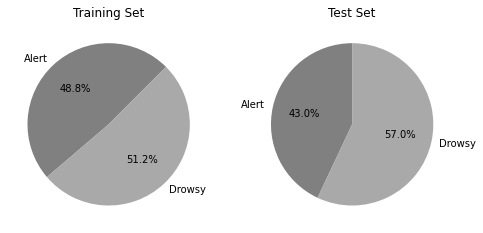

In [ ]:
# class distribution
label = 'Alert', 'Drowsy'
plt.figure(figsize = (8,8))
plt.subplot(121)
plt.title("Training Set")
plt.pie(df_train.groupby('Y').size(), labels = label, autopct='%1.1f%%', startangle=45, colors={"grey", "darkgrey"})
plt.subplot(122)
plt.title("Test Set")
plt.pie(df_test.groupby('Y').size(), labels = label, autopct='%1.1f%%', startangle=90, colors={"grey", "darkgrey"})
plt.show()

In [ ]:
x_shaped_train  = np.array(x_train).reshape(1632,5,4)  # Reshape the 2 Dimensional data into 3D representation (LSTM only accepts 3D Data).
x_shaped_test  = np.array(x_test).reshape(480,5,4)     
y_train = np.array(y_train)x
y_test = np.array(y_test)

y_shaped_train  = []
# Reshape the dataframe containing only labels
for i in range(0, len(y_train), 5):
  y_shaped_train.append([y_train[i]])
print(len(y_shaped_train))

y_shaped_test  = []
for i in range(0, len(y_test), 5):
  y_shaped_test.append([y_test[i]])
print(len(y_shaped_test))

1632
480


In [ ]:
x_shaped_train.shape  # shape of x_shaped_train dataframe

(1632, 5, 4)

In [ ]:
x_shaped_test.shape   # shape of x_shaped_test dataframe

(480, 5, 4)

In [ ]:
y_shaped_train = np.array(y_shaped_train) # shape of y_shaped_train dataframe
y_shaped_train.shape

(1632, 1)

In [ ]:
y_shaped_test = np.array(y_shaped_test)   # shape of y_shaped_test dataframe    
y_shaped_test.shape

(480, 1)

In [ ]:
#Creation of LSTM Model Architecture
metrics = ['accuracy']
model = Sequential()
model.add(Dense(1024, activation='sigmoid'))       
model.add(LSTM(512, return_sequences=True,
                       input_shape=(5, 4,),
                       dropout=0.5))

model.add(Flatten())
# Dense is fully connected layer. 16 hidden units
# activation for lstm is basically sigmoid or tanh
model.add(Dense(216, activation='sigmoid')) #FC1
model.add(Dense(32, activation='tanh')) #FC2
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))#FC3
model.add(Dropout(0.5))
model.add(Dense(1, activation='tanh'))#Output Layer
optimizer = Adam(lr=0.00005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)
model.fit(x_shaped_train, y_shaped_train, validation_data = (x_shaped_test,y_shaped_test), epochs=50, batch_size=  10)
path = "/content/gdrive/MyDrive/data/lstmmodelgpu.pth"
torch.save(model, path)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


164/164 [==============================] - 12s 40ms/step - loss: 3.2923 - accuracy: 0.5000 - val_loss: 0.6549 - val_accuracy: 0.5667
Epoch 2/50
164/164 [==============================] - 6s 37ms/step - loss: 1.4849 - accuracy: 0.5110 - val_loss: 0.6236 - val_accuracy: 0.5667
Epoch 3/50
164/164 [==============================] - 6s 38ms/step - loss: 1.5026 - accuracy: 0.5098 - val_loss: 0.6150 - val_accuracy: 0.8313
Epoch 4/50
164/164 [==============================] - 6s 36ms/step - loss: 1.4857 - accuracy: 0.5306 - val_loss: 0.5256 - val_accuracy: 0.8687
Epoch 5/50
164/164 [==============================] - 6s 38ms/step - loss: 1.4487 - accuracy: 0.5594 - val_loss: 0.5432 - val_accuracy: 0.8229
Epoch 6/50
164/164 [==============================] - 6s 39ms/step - loss: 1.2337 - accuracy: 0.5833 - val_loss: 0.5128 - val_accuracy: 0.8604
Epoch 7/50
164/164 [==============================] - 7s 40ms/step - loss: 1.1432 - accuracy: 0.6011 - val_loss: 0.3928 - val_accuracy: 0.8708
Epoch 8/5

In [ ]:
predict=(model.predict(x_shaped_test) > 0.5).astype("int32") # Checking how it predicts
print(predict)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]


In [ ]:
#import libraries for testing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

In [ ]:
pred_rnn=(model.predict(x_shaped_test) > 0.5).astype("int32")
y_score_10 = model.predict_on_batch(x_shaped_test)
acc10 = accuracy_score(y_shaped_test, pred_rnn)                   # calculation of accuracy score
f1_score_10 = metrics.f1_score(y_shaped_test, np.array(pred_rnn)) # calculation of f1 score
roc_10 = metrics.roc_auc_score(y_shaped_test, y_score_10)         # calculation of roc score
print([acc10, f1_score_10, roc_10])
cf_matrix = confusion_matrix(y_shaped_test, pred_rnn)             # calculate confusion matrix
print(cf_matrix)

[0.8708333333333333, 0.8825757575757577, 0.9236248585972849]
[[185  23]
 [ 39 233]]


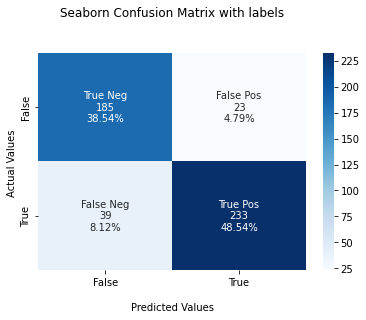

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()


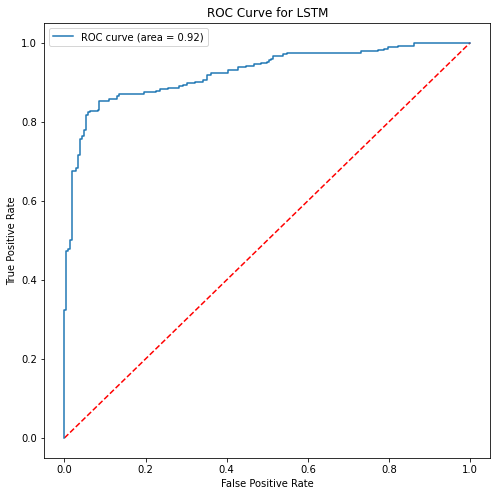

In [ ]:
# plotting roc_curve using roc_score
plt.figure(figsize=(8,8))                        
plt.plot([0, 1], [0, 1],'r--')
fpr, tpr, thresholds = roc_curve(y_shaped_test, y_score_10)
plt.plot(fpr, tpr, label= 'ROC curve (area = %0.2f)' % roc_10)
plt.title('ROC Curve for LSTM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()